Implementation of the wavelet transform as described in "A Practical Guide to Wavelet Analysis" by Torrence and Compo (1998).

In [1]:
import numpy             as np 
import matplotlib.pyplot as plt
import scipy
import scipy.signal

The morlet wavelet funtion in given by:

$\psi_{0}(\eta) = \pi^{-1/4}\exp{(i\omega_{0}\eta)\exp{(-\eta^2/2)}}$,

where $w_{0}$ is the nondimensional frequency, and $\eta$ a nondimensional "time" parameter.

In [2]:
def morlet(w_0, eta):
	return np.pi**(-1/4) * np.exp(1j*w_0*eta) * np.exp(-eta**2 / 2)

We can plot the morlet function real and imaginary parts:

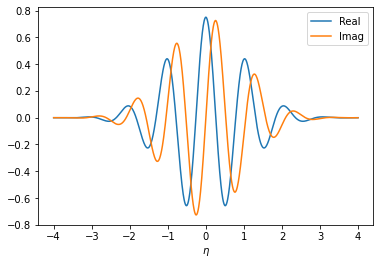

In [3]:
#@title
# Plotting the morlet wavelet function
w_0 = 6
eta = np.linspace(-4,4,1000)

m   = morlet(w_0, eta)
plt.plot(eta, m.real, label='Real')
plt.plot(eta, m.imag, label='Imag')
plt.xlabel(r'$\eta$')
plt.legend()

For a discrete time-series $x_{n}$, with equal spacing $\delta t$ between observations, and $n=0\dots N-1$, being $N$ the length of the time-series, the wavelet transform is defined as:

$W_{n}(s) = \sum_{n^{'}=0}^{N-1}x_{n^{'}}\psi^{*}[(n^{'}-n)\delta t/s]$,

where $s$ is called the wavelet scale.

By using the convolution theorem $W_{n}(s)$ can be computed as the product of the fourier transforms of $x_{n}$, and $\psi(t/s)$, written as $\tilde{x}_{n}$, and $\tilde{\psi}(s\omega)$, respectively.

$W_{n}(s) = \sum_{k=0}^{N-1}\tilde{x}_{n}\tilde{\psi^{*}}(s\omega_k)\exp{(i\omega_kn\delta_t)}$, 

where $\omega_k = 2\pi k/(N\delta t)$ if $k\leq N/2$, and $-\omega_k = 2\pi k/(N\delta t)$, otherwise.

To ensure that  wavelet transforms for each scale $s$ are comparable, in the expression above are normalized at each scale and given by:

$\tilde{\psi}(s\omega_k) = (\frac{2\pi s}{\delta t})^{0.5}\tilde{\psi}_{0}(s\omega_k)$.

Now let's implement the morlet transform.

In [4]:
# Heaviside function
def heaviside(x):
  return (x > 0).astype(int)
# Fourier transform of morlet function
def fft_morlet(w, w_0, s):
  return np.pi**(-1/4) * np.exp(-((s*w-w_0)**2)/2) 

In [5]:
def morlet_transform(x, freqs, w_0, fs):

  N  = len(x)
  s  = w_0/freqs

  omega  = np.concatenate( (np.arange(0, N/2), np.arange(-np.ceil(N/2), 0) ) ) * fs/N

  fftx   = scipy.fft.fft(x)
  W      = np.zeros([N, s.shape[0]]) * (1+1j)
  for i in range(s.shape[0]):
    # Normalised psi
    psi = (2*np.pi*s[i]*fs)**0.5 * fft_morlet(omega,w_0,s[i])
    W[:,i]   = scipy.fft.ifft(fftx*np.conj(psi))

  return W

To test let's implement the auto-regressive system with two coupled variables presented in Dhamala et. al., (2008), and given by:

$X(t) = 0.55X(t-1) - 0.8X(t-2) + C(t)Y(t-1) + \epsilon_X(t)$,

and, 

$Y(t) = 0.55Y(t-1) - 0.8Y(t-2) + \epsilon_Y(t)$,

where $\epsilon_X(t)$, and $\epsilon_Y(t)$ are two uncorrelated Gaussian noises and $C(t)$ is the time dependent coupling constant, that is $C=0.25$ for times lower than $2.25$s and zero otherwise.

In [8]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    T = N / Fs
    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in range(Trials):
        
        np.random.seed(i*1000)
          
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] +E[t,1]

    Z = np.zeros([2, Trials, N])

    Z[0] = X
    Z[1] = Y

    return Z

In [22]:
# Generating signals
N  = 900      # Number of observations
Fs = 200      # Sampling frequency
dt = 1.0 / Fs # Time resolution
C  = 0.25     # Coupling parameter
Trials = 100  # Number of trials

cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])
Z = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=2.25, cov=cov)

In [38]:
freqs = np.arange(0.1,100,.1)
w_0   = 6

Wx = np.zeros([Trials, N,len(freqs)]) * (1 + 1j)
Wy = np.zeros([Trials, N,len(freqs)]) * (1 + 1j)
for t in range(Trials):
  Wx[t,:,:] = morlet_transform(Z[0,t], freqs, w_0, Fs)
  Wy[t,:,:] = morlet_transform(Z[1,t], freqs, w_0, Fs)

The wavalet spectrum  of a signal $X$ can be computed as $|W_x(s)|^2 = W_xW_x^{*}$, analogously the cros spectrum between two signals $X$, and $Y$ is $W_xW_y^{*}$. Those quantities can also be computed as single-trial estimates and then averaged.

In [55]:
Sxx = np.zeros([Trials, N,len(freqs)]) * (1 + 1j)
Syy = np.zeros([Trials, N,len(freqs)]) * (1 + 1j)
Sxy = np.zeros([Trials, N,len(freqs)]) * (1 + 1j)

for t in range(Trials):
  Sxx[t,:,:] = (Wx[t]*np.conj(Wx[t])).real
  Syy[t,:,:] = (Wy[t]*np.conj(Wy[t])).real
  Sxy[t,:,:] = ((Wx[t]*np.conj(Wy[t])) * np.conj((Wx[t]*np.conj(Wy[t])))).real

Sxx = Sxx.mean(axis=0).real.T
Syy = Syy.mean(axis=0).real.T
Sxy = Sxy.mean(axis=0).real.T

Finally, let's plot the results.

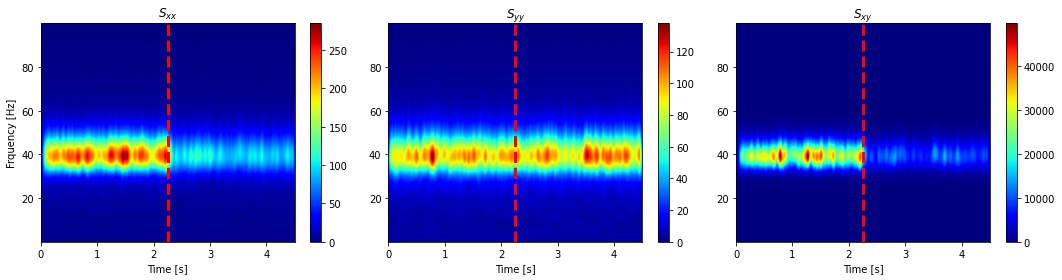

In [56]:
#@title
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(Sxx, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs, freqs[0],freqs[-1]]);plt.colorbar()
plt.vlines(2.25, 0.1, freqs[-1], colors='r', linestyles='--', lw=3)
plt.ylabel('Frquency [Hz]')
plt.xlabel('Time [s]')
plt.title(r'$S_{xx}$')
plt.subplot(1,3,2)
plt.imshow(Syy, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs, freqs[0],freqs[-1]]);plt.colorbar()
plt.xlabel('Time [s]')
plt.title(r'$S_{yy}$')
plt.vlines(2.25, 0.1, freqs[-1], colors='r', linestyles='--', lw=3)
plt.subplot(1,3,3)
plt.imshow(np.abs(Sxy), aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs, freqs[0],freqs[-1]]);plt.colorbar()
plt.xlabel('Time [s]')
plt.title(r'$S_{xy}$')
plt.vlines(2.25, 0.1, freqs[-1], colors='r', linestyles='--', lw=3)
plt.tight_layout()